### Topic: K-Means Clustering - Applications (Image Segmentation)
- Theory and Algo
- Mathematical Background
- Image Segmentation - What is it?
- Image Segmentation - Why do we need it?
- Perform Image Segmentation using K-Means Clustering (Look at Lloyd and Elken Algorithm)
- Explore different values of K
- Metrics used to find the perfect value of K (Variance, KL DIvergence, Correlation, time taken, RGB Histograms)
- Alogrithm to find the perfect value of K (elbow and silhouette method)
- The good and the bad

(Classification if less topics - Fashion MNIST)

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import time

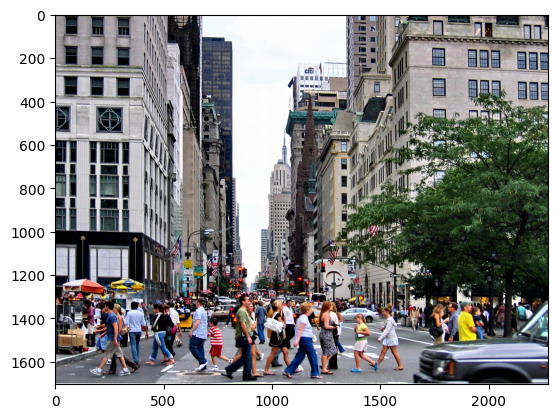

In [13]:
image = plt.imread('street.jpg')
plt.imshow(image)
plt.show()

In [14]:
class ImageSegmentation:
    def __init__(self, num_clusters):
        self.num_clusters = num_clusters
        self.kmeans = KMeans(n_clusters=num_clusters, n_init=10)
        self.seg_image = None
        self.cluster_centers = None
        self.colors = np.zeros((num_clusters, 1, 3), dtype=np.uint8)

    def normalize(image):
        if len(image.shape) == 2:
            return (image - np.min(image)) / (np.max(image) - np.min(image))
        
        elif len(image.shape) == 3:
            new = np.zeros(image.shape, dtype=np.float32)
            for k in range(3):
                new[:, :, k] = (image[:, :, k] - np.min(image[:, :, k])) / (np.max(image[:, :, k]) - np.min(image[:, :, k]))

            return new
    
    def fit(self, image):
        vectorized = np.float32(image.reshape((-1, 3)))
        self.kmeans.fit(vectorized)
        self.seg_image = self.kmeans.predict(vectorized).reshape(image.shape[:2])
        self.cluster_centers = np.array(self.kmeans.cluster_centers_, dtype=np.uint8)
        
        for i in range(self.num_clusters):
            self.colors[i, 0, 0] = self.cluster_centers[i, 0]
            self.colors[i, 0, 1] = self.cluster_centers[i, 1]
            self.colors[i, 0, 2] = self.cluster_centers[i, 2]

    def get_segmented_image(self):
        new_image = np.zeros((self.seg_image.shape[0], self.seg_image.shape[1], 3), dtype=np.uint8)
        for i in range(self.num_clusters):
            new_image[self.seg_image == i, :] = self.colors[i]

        return new_image

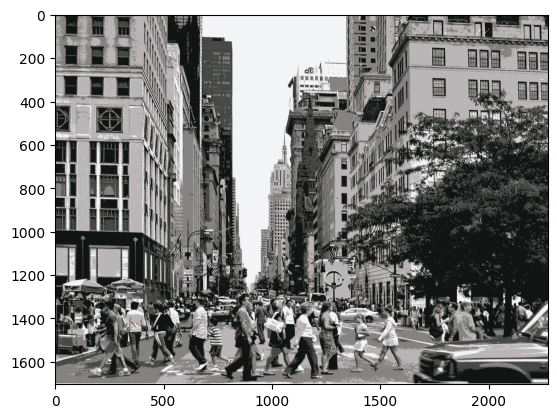

In [21]:
imgseg = ImageSegmentation(num_clusters = 5)
imgseg.fit(image)
plt.imshow(imgseg.get_segmented_image())
plt.show()

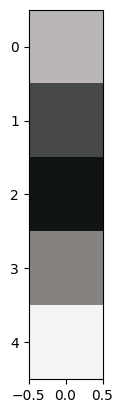

In [22]:
plt.imshow(imgseg.colors)
plt.show()

In [16]:
def get_elbow_plot(image, end=10):
    inertias = []
    times = []
    
    for i in range(1, end+1):
        
        cur_inertia = 0
        cur_time = 0
        imgseg = ImageSegmentation(num_clusters = i)
        
        for j in range(5):
            st = time.time()
            imgseg.fit(image)
            cur_inertia += imgseg.kmeans.inertia_
            cur_time += time.time() - st
        
        inertias.append(cur_inertia / 5)
        times.append(cur_time / 5)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, end+1), inertias, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.title('Elbow plot')
    plt.subplot(1, 2, 2)
    plt.plot(range(1, end+1), times, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Time')
    plt.title('Time plot')
    plt.grid()
    plt.show()

In [ ]:
get_elbow_plot(image, end=15)

In [ ]:
import numpy as np
from skimage.color import rgb2gray
from skimage.feature import greycomatrix, greycoprops, local_binary_pattern
from sklearn.cluster import KMeans

# Load the image
image = plt.imread('bug.jpg')

# Perform K-means clustering
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
segmented_image = kmeans.fit_predict(image.reshape(-1, 3)).reshape(image.shape[:2])

# Convert the image to grayscale
gray_image = rgb2gray(image)

# Initialize arrays for texture features
glcm_features = np.zeros((n_clusters, 4), dtype=np.float32)
lbp_features = np.zeros((n_clusters, n_points), dtype=np.float32)

# Iterate over each segment
for i in range(n_clusters):
    # Extract the segment
    segment = gray_image[segmented_image == i]
    
    # Compute GLCM features
    glcm = greycomatrix(segment, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], symmetric=True, normed=True)
    glcm_features[i, 0] = greycoprops(glcm, "contrast")[0, 0]
    glcm_features[i, 1] = greycoprops(glcm, "dissimilarity")[0, 0]
    glcm_features[i, 2] = greycoprops(glcm, "homogeneity")[0, 0]
    glcm_features[i, 3] = greycoprops(glcm, "energy")[0, 0]
    
    # Compute LBP features
    lbp = local_binary_pattern(segment, n_points, radius, method="uniform")
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    lbp_features[i, :] = hist / np.sum(hist)
